Let me share the experiments performed with it's LB score and the visualization on deciding the final submission for now.

* [Experiments](#section-one)
    - [Alexnet with input image size as 224x224](#subsection-one)
    - [VGG19 wit input image size as 224x224](#subsection-two)
* [Outlier Detection](#section-two)
* [Experiments after outlier detection](#section-three)
    - [VGG19 with input image size as 224x224](#subsection-oneinthree)
    - [ResNext with input image size as 512x512](#subsection-twointhree)
* [Conclusion](#section-four)

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import torchvision.models as models
import torch.utils.model_zoo as model_zoo
import cv2
from torch import nn
import torchvision
import os
from sklearn.manifold import TSNE
from albumentations import (Compose, Normalize, Resize)
import time
from albumentations.pytorch import ToTensor
from tqdm.notebook import tqdm
import json

In [2]:
class Load_Dataset(torch.utils.data.Dataset):
    def __init__(self,df,image_size):
        self.image_paths = df['image_id']
        self.labels = df['label']
        self.default_transform = Compose([
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            Resize(image_size,image_size),
            ToTensor()
            
        ])
        
    def __len__(self):
        return self.image_paths.shape[0]
    
    def __getitem__(self,i):
        image_name = self.image_paths[i]
        img_path = os.path.join('../input/cassava-leaf-disease-classification/train_images',image_name)
        image = cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2RGB)
        image = self.default_transform(image=image)['image']
        label = torch.tensor(self.labels[i])

        return image,label

In [3]:
train = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
train

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


In [4]:
import json
#maping the class labels mentioned in json file wiht its respective disease name
disease_names = open('../input/cassava-leaf-disease-classification/'+'label_num_to_disease_map.json')
disease_names = json.load(disease_names)
disease_names

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

In [5]:
train['disease_name'] = train['label'].apply(lambda x: disease_names[str(x)])

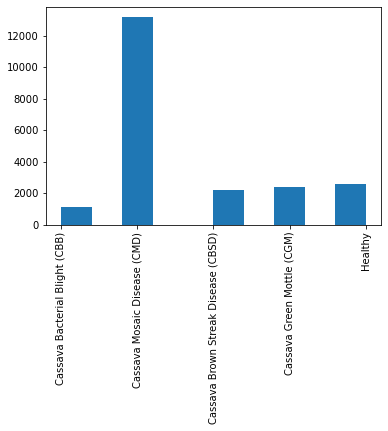

In [6]:
data = train['disease_name']
p = plt.hist(data)
plt.xticks(rotation='vertical')

plt.show()

<a id="section-one"></a>
# Experiments

<a id="subsection-one"></a>
## Alexnet with input image size as 224x224

In [7]:
num_classes=5
model= model = models.__dict__['alexnet'](num_classes=num_classes)
model.load_state_dict(torch.load('../input/pretrained-model-plant-disease/alexnet_epoch_4'))
model =model.cuda()

In [8]:
#Load dataset
img_size=224
train_data = Load_Dataset(train,img_size)
train_loader = torch.utils.data.DataLoader(train_data,batch_size=128)


In [9]:
model.classifier = nn.Sequential(*list(model.classifier.children())[:-2])
output_descriptor = np.zeros((1,4096))
output_label = np.zeros((1))
device='cuda:0'
#evaluating the image with pretrained model
model.eval()
with torch.no_grad():
    for _, (images,labels) in tqdm(enumerate(train_loader)):
        images,labels = images.to(device),labels.to(device)
        pred = model(images)
        #concatenating all the outputs and labels as a batch of 128 and store in a variable
        output_descriptor =np.concatenate((output_descriptor,pred.cpu().numpy().squeeze()),0)
        output_label = np.concatenate((output_label,labels.cpu().numpy()))
output_descriptor = output_descriptor[1:]
output_label = output_label[1:]

In [10]:
st_time = time.time()
t_sne = TSNE(random_state=2020)
t_sne_tr = t_sne.fit_transform(output_descriptor)
print('TNSE done; Time take {} seconds'.format(time.time()-st_time))



TNSE done; Time take 2199.0096957683563 seconds


In [11]:
##T-SNE df
tsne_tr = pd.DataFrame()
for idx in range(t_sne_tr.shape[1]):
    tsne_tr['t_sne'+str(idx+1)] = t_sne_tr[:,idx]
tsne_tr['label'] = output_label.astype(int)
tsne_tr['disease_name'] = tsne_tr['label'].apply(lambda x: disease_names[str(x)])
tsne_tr.head()

,t_sne1,t_sne2,label,disease_name
0,-41.900143,45.835495,0,Cassava Bacterial Blight (CBB)
1,61.688641,-19.197992,3,Cassava Mosaic Disease (CMD)
2,-18.143314,10.189492,1,Cassava Brown Streak Disease (CBSD)
3,-13.529616,8.266199,1,Cassava Brown Streak Disease (CBSD)
4,-13.193207,-0.605124,3,Cassava Mosaic Disease (CMD)


In [12]:
import plotly.graph_objects as go
fig = go.Figure()
colors = ['rgb(243, 247, 15)','rgb(13, 160, 200)','rgb(190, 81, 249)','rgb(248, 104, 73)','rgb(0,255,0)']
for idx,dn in enumerate(tsne_tr['disease_name'].unique()):
    df = tsne_tr[tsne_tr['disease_name'] == dn]
    fig.add_trace(go.Scatter(x=df['t_sne1'],y=df['t_sne2'],mode='markers',marker_color = colors[idx],name=dn))
fig.update_layout(title='Trained Alexnet model performance')
fig.update_xaxes(title_text="TSNE_1")
fig.update_yaxes(title_text="TSNE_2")
fig.show()

Almost all classes are in the same cluster, the only difference we can see is that the class CMD is separated from all other classes but that again is due to the imbalance in the data points.

<a id="subsection-two"></a>
## VGG19 with input image size as 224x224

In [13]:

model_path='../input/pretrained-model-plant-disease/vgg19_epoch_20'
model= model = models.__dict__['vgg19'](num_classes=num_classes)
pretrained_state = torch.load(model_path)
new_pretrained_state= OrderedDict()
for k, v in pretrained_state.items():
    layer_name = k.replace("module.", "")
    new_pretrained_state[layer_name] = v
model.load_state_dict(new_pretrained_state)
model= model.cuda()

In [14]:
#Load dataset
img_size=224
train_data = Load_Dataset(train,img_size)
train_loader = torch.utils.data.DataLoader(train_data,batch_size=128)


In [15]:
#taking only the first layer from classifier (4096)
model.classifier = torch.nn.Sequential(model.classifier[0])
output_descriptor = np.zeros((1,4096))
output_label = np.zeros((1))
device='cuda:0'
#evaluating the image with pretrained model
model.eval()
with torch.no_grad():
    for _, (images,labels) in tqdm(enumerate(train_loader)):
        images,labels = images.to(device),labels.to(device)
        
        pred = model(images)
        #concatenating all the outputs and labels as a batch of 128 and store in a variable
        output_descriptor =np.concatenate((output_descriptor,pred.cpu().numpy().squeeze()),0)
        output_label = np.concatenate((output_label,labels.cpu().numpy()))
output_descriptor = output_descriptor[1:]
output_label = output_label[1:]

In [16]:
st_time = time.time()
t_sne = TSNE(random_state=2020)
t_sne_tr = t_sne.fit_transform(output_descriptor)
print('TNSE done; Time take {} seconds'.format(time.time()-st_time))



TNSE done; Time take 1375.2005348205566 seconds


In [17]:
##T-SNE df
tsne_tr = pd.DataFrame()
for idx in range(t_sne_tr.shape[1]):
    tsne_tr['t_sne'+str(idx+1)] = t_sne_tr[:,idx]
tsne_tr['label'] = output_label.astype(int)
tsne_tr['disease_name'] = tsne_tr['label'].apply(lambda x: disease_names[str(x)])
tsne_tr.head()

,t_sne1,t_sne2,label,disease_name
0,-36.093735,24.628874,0,Cassava Bacterial Blight (CBB)
1,47.390282,-21.400660,3,Cassava Mosaic Disease (CMD)
2,-69.679489,3.484016,1,Cassava Brown Streak Disease (CBSD)
3,-55.865807,-5.665532,1,Cassava Brown Streak Disease (CBSD)
4,49.282757,1.525493,3,Cassava Mosaic Disease (CMD)


In [18]:
import plotly.graph_objects as go
fig = go.Figure()
colors = ['rgb(243, 247, 15)','rgb(13, 160, 200)','rgb(190, 81, 249)','rgb(248, 104, 73)','rgb(0,255,0)']
for idx,dn in enumerate(tsne_tr['disease_name'].unique()):
    df = tsne_tr[tsne_tr['disease_name'] == dn]
    fig.add_trace(go.Scatter(x=df['t_sne1'],y=df['t_sne2'],mode='markers',marker_color = colors[idx],name=dn))
fig.update_layout(title='VGG TSNE 1 Vs TSNE 2')
fig.update_xaxes(title_text="TSNE_1")
fig.update_yaxes(title_text="TSNE_2")
fig.show()

From the plot, the trained model can identify the class CMD better (due to the imablance in the class data) as CMD has almost 50% data higher than any class in the dataset. If you infer more, we can find the model finds it difficult to differentiate between Healthy and CBB .The CBB class is completely hidden behind the healthy class.

<a id="section-two"></a>
# Outlier Detection

Notebook from the below link, gives an outstanding way on detecting outliers from the dataset.

https://www.kaggle.com/ramjib/cassava-leaf-disease-eda-and-outliers

Chosing the outlier detection using normalized mean distribution of the images, around 40 images from the dataset are found to be outliers. The following is the way to find the outliers based on normalized mean of the images

In [19]:
for idx in tqdm(train.index):
    img_name = train.loc[idx,'image_id']
    #reading the image and converting BGR color space to RGB
    img = cv2.cvtColor(cv2.imread('../input/cassava-leaf-disease-classification/train_images/'+img_name), cv2.COLOR_BGR2RGB)
    
    #normalize the image in the range [0,1]
    norm_image = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    
    #calculate mean for each normalized image
    train.loc[idx,'Normalized_Mean'] = norm_image.mean()
fig = go.Figure()
colors = ['rgb(243, 247, 15)','rgb(13, 160, 200)','rgb(190, 81, 249)','rgb(248, 104, 73)','rgb(0,255,0)']
for idx,class_name in enumerate(train['disease_name'].unique()):
    fig.add_trace(go.Box(y=train[train['disease_name'] == class_name]['Normalized_Mean'],
                        name=class_name,showlegend=False,
                        marker_color=colors[idx]))
fig.update_layout(title='Outlier Detection - Box Plot')
fig.show()

Found the following range as outlier in each class of the dataset.

In [20]:
outlier_mean ={}
outlier_mean['Cassava Bacterial Blight (CBB)'] = [0.17,0.58]
outlier_mean['Cassava Mosaic Disease (CMD)']=[0.19,0.64]
outlier_mean['Cassava Brown Streak Disease (CBSD)'] =[0.158,0.64]
outlier_mean['Cassava Green Mottle (CGM)']=[0.2,0.64]
outlier_mean['Healthy']=[0.175,0.64]
outlier_mean

{'Cassava Bacterial Blight (CBB)': [0.17, 0.58],
 'Cassava Mosaic Disease (CMD)': [0.19, 0.64],
 'Cassava Brown Streak Disease (CBSD)': [0.158, 0.64],
 'Cassava Green Mottle (CGM)': [0.2, 0.64],
 'Healthy': [0.175, 0.64]}

In [21]:
outliers=[]
#filtering only   'Healthy' class from original data
for disease in train['disease_name'].unique():
    dis  = train[train['disease_name'] ==    disease]
    print('Number of Images in '+disease+ ' Class: '+str(len(dis)))

    #filtering the CMD data for which Mean is between 0.175 and 0.64 (observation from box plot)
    outliers_dis = dis[dis['Normalized_Mean'].between(outlier_mean[disease][0],outlier_mean[disease][1],inclusive=True)]
    # filter only the rows which are not in above list of images
    outliers_dis = dis[~dis['image_id'].isin(outliers_dis['image_id'])]
    print('Number of Outlier Images in '+disease+ ' Class: '+str(len(outliers_dis))+'\n')
    print('../input/cassava-leaf-disease-classification/train_images/'+outliers_dis['image_id'].values)
    outliers.extend(list(outliers_dis['image_id'].values))

Number of Images in Cassava Bacterial Blight (CBB) Class: 1087
Number of Outlier Images in Cassava Bacterial Blight (CBB) Class: 9

['../input/cassava-leaf-disease-classification/train_images/1033403106.jpg'
 '../input/cassava-leaf-disease-classification/train_images/1166973570.jpg'
 '../input/cassava-leaf-disease-classification/train_images/1522449555.jpg'
 '../input/cassava-leaf-disease-classification/train_images/1635136764.jpg'
 '../input/cassava-leaf-disease-classification/train_images/2221240763.jpg'
 '../input/cassava-leaf-disease-classification/train_images/2298308938.jpg'
 '../input/cassava-leaf-disease-classification/train_images/2889965946.jpg'
 '../input/cassava-leaf-disease-classification/train_images/4250554784.jpg'
 '../input/cassava-leaf-disease-classification/train_images/534270890.jpg']
Number of Images in Cassava Mosaic Disease (CMD) Class: 13158
Number of Outlier Images in Cassava Mosaic Disease (CMD) Class: 18

['../input/cassava-leaf-disease-classification/train_i

In [22]:
indices = train[train['image_id'].isin(outliers)].index
train.drop(indices,axis=0,inplace=True)
train.reset_index(inplace=True)
print('Number of Train data after removing outliers: ',len(train))

Number of Train data after removing outliers:  21357


In [23]:
#visulaizing the performance for all the train images
train = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')

<a id="section-three"></a>
# Experiments after removing outliers

<a id="subsection-oneinthree"></a>
## VGG19 with input image size as 224x224

In [24]:
num_classes=5
model_path='../input/pretrained-model-plant-disease/vgg19_epoch_20_oulier_romoved'
model= model = models.__dict__['vgg19'](num_classes=num_classes)
pretrained_state = torch.load(model_path)
new_pretrained_state= OrderedDict()
for k, v in pretrained_state.items():
    layer_name = k.replace("module.", "")
    new_pretrained_state[layer_name] = v
model.load_state_dict(new_pretrained_state)
model= model.cuda()

#Load dataset
img_size=224
train_data = Load_Dataset(train,img_size)
train_loader = torch.utils.data.DataLoader(train_data,batch_size=128)


#taking only the first layer from classifier (4096)
model.classifier = torch.nn.Sequential(model.classifier[0])
output_descriptor = np.zeros((1,4096))
output_label = np.zeros((1))
device='cuda:0'
#evaluating the image with pretrained model
model.eval()
with torch.no_grad():
    for _, (images,labels) in tqdm(enumerate(train_loader)):
        images,labels = images.to(device),labels.to(device)
        
        pred = model(images)
        #concatenating all the outputs and labels as a batch of 128 and store in a variable
        output_descriptor =np.concatenate((output_descriptor,pred.cpu().numpy().squeeze()),0)
        output_label = np.concatenate((output_label,labels.cpu().numpy()))
output_descriptor = output_descriptor[1:]
output_label = output_label[1:]


In [25]:
st_time = time.time()
t_sne = TSNE(random_state=2020)
t_sne_tr = t_sne.fit_transform(output_descriptor)
print('TNSE done; Time take {} seconds'.format(time.time()-st_time))



TNSE done; Time take 1545.3058023452759 seconds


In [26]:

tsne_tr = pd.DataFrame()
for idx in range(t_sne_tr.shape[1]):
    tsne_tr['t_sne'+str(idx+1)] = t_sne_tr[:,idx]
tsne_tr['label'] = output_label.astype(int)
tsne_tr['disease_name'] = tsne_tr['label'].apply(lambda x: disease_names[str(x)])
tsne_tr.head()

,t_sne1,t_sne2,label,disease_name
0,-40.077789,21.195574,0,Cassava Bacterial Blight (CBB)
1,43.300632,10.585462,3,Cassava Mosaic Disease (CMD)
2,-59.160725,5.008103,1,Cassava Brown Streak Disease (CBSD)
3,-57.869583,-15.688855,1,Cassava Brown Streak Disease (CBSD)
4,21.273369,-30.644266,3,Cassava Mosaic Disease (CMD)


In [27]:
import plotly.graph_objects as go
fig = go.Figure()
colors = ['rgb(243, 247, 15)','rgb(13, 160, 200)','rgb(190, 81, 249)','rgb(248, 104, 73)','rgb(0,255,0)']
for idx,dn in enumerate(tsne_tr['disease_name'].unique()):
    df = tsne_tr[tsne_tr['disease_name'] == dn]
    fig.add_trace(go.Scatter(x=df['t_sne1'],y=df['t_sne2'],mode='markers',marker_color = colors[idx],name=dn))
fig.update_layout(title='VGG after outliers removal TSNE 1 Vs TSNE 2')
fig.update_xaxes(title_text="TSNE_1")
fig.update_yaxes(title_text="TSNE_2")
fig.show()

The effect in removal of outliers is evident with the class CBSD. I found the false classification with CBSD class is lesser comparitively. But still the model cannot separate the Healthy and CBB class

Frequent discussions in this competition gave the following insights
1. Image size of 512x512 works better
2. Smaller architectures (like VGG,Resnet) underfits and bigger architectures (like EffNetb7,b5) overfits


So,I experimented on ResNext with image size 512x512

<a id="subsection-twointhree"></a>
## ResNext with input image size as 512x512

In [28]:

model_path='../input/pretrained-model-plant-disease/best-model-resnext_outliers_removal_epoch_20'
model = torchvision.models.resnext50_32x4d(pretrained=False)
    
#     for parameter in model.parameters():
#         parameter.requires_grad = False
fc_inputs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(fc_inputs, 5),
    nn.Softmax(dim=1) # For using NLLLoss()
)
use_gpu = torch.cuda.is_available()
pretrained_state = torch.load(model_path,map_location=torch.device('cpu'))
new_pretrained_state= OrderedDict()
   
for k, v in pretrained_state.items():
    layer_name = k.replace("module.", "")
    new_pretrained_state[layer_name] = v
model.load_state_dict(new_pretrained_state)



<All keys matched successfully>

In [29]:
model.fc = model.fc[0]
fc_inputs = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(fc_inputs,fc_inputs))
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [30]:
#Load dataset
img_size=512
train_data = Load_Dataset(train,img_size)
train_loader = torch.utils.data.DataLoader(train_data,batch_size=128)

In [31]:

output_descriptor = np.zeros((1,2048))
output_label = np.zeros((1))
device='cuda:0'
#evaluating the image with pretrained model'
model=model.cuda()
model.eval()
with torch.no_grad():
    for _, (images,labels) in tqdm(enumerate(train_loader)):
        images,labels = images.to(device),labels.to(device)
        
        pred = model(images)


        #concatenating all the outputs and labels as a batch of 128 and store in a variable
        output_descriptor =np.concatenate((output_descriptor,pred.cpu().numpy().squeeze()),0)
        output_label = np.concatenate((output_label,labels.cpu().numpy()))
output_descriptor = output_descriptor[1:]
output_label = output_label[1:]



st_time = time.time()
t_sne = TSNE(random_state=2020)
t_sne_tr = t_sne.fit_transform(output_descriptor)
print('TNSE done; Time take {} seconds'.format(time.time()-st_time))




TNSE done; Time take 816.6934990882874 seconds


In [32]:

tsne_tr = pd.DataFrame()
for idx in range(t_sne_tr.shape[1]):
    tsne_tr['t_sne'+str(idx+1)] = t_sne_tr[:,idx]
tsne_tr['label'] = output_label.astype(int)
tsne_tr['disease_name'] = tsne_tr['label'].apply(lambda x: disease_names[str(x)])
tsne_tr.head()

,t_sne1,t_sne2,label,disease_name
0,-33.502766,26.800123,0,Cassava Bacterial Blight (CBB)
1,19.915380,-28.785027,3,Cassava Mosaic Disease (CMD)
2,-27.219883,-34.253204,1,Cassava Brown Streak Disease (CBSD)
3,-55.719791,38.514904,1,Cassava Brown Streak Disease (CBSD)
4,41.824139,11.444049,3,Cassava Mosaic Disease (CMD)


In [33]:
import plotly.graph_objects as go
fig = go.Figure()
colors = ['rgb(243, 247, 15)','rgb(13, 160, 200)','rgb(190, 81, 249)','rgb(248, 104, 73)','rgb(0,255,0)']
for idx,dn in enumerate(tsne_tr['disease_name'].unique()):
    df = tsne_tr[tsne_tr['disease_name'] == dn]
    fig.add_trace(go.Scatter(x=df['t_sne1'],y=df['t_sne2'],mode='markers',marker_color = colors[idx],name=dn))
fig.update_layout(title='Resnext after outliers removal TSNE 1 Vs TSNE 2')
fig.update_xaxes(title_text="TSNE_1")
fig.update_yaxes(title_text="TSNE_2")
fig.show()

Though the CBB and Healthy not yet separated, the other classes are more separated than bove experiments. The overlap between the classes CGM and Healthy is less and also between the classes CMD and CGM.

**Insights from the visualizations:**
Comparatively the RexNext experiment gave better separation of classes among all the above experiments.

But the LB board results says the opposite. Below are the LB results of all the experiments

In [34]:
models =['Alexnet' ,'VGG19', 'VGG19', 'ResNext']
image_size= ['224x224','224x224', '224x224','512x512']
out_det = ['Not performed','Not performed','Performed','Performed']
lb_score =[0.784, 0.839, 0.824,0.818]

fig = go.Figure()
fig.add_trace(
        go.Table(
            header=dict(
                values=["Models","Image size", "Outlier detection","LB score"],
                font=dict(size=10),
                align="center"
            ),
            cells=dict(
                values=[models,image_size,out_det,lb_score],
                align = "center")
        ))


fig.update_layout(title='Results in LB')
fig.show()

<a id="section-four"></a>
# Conclusion

The public LB may stand correct and may not, always go with the validation performance and the result visualizations of the models. We all know the reason-the public LB has only 31% of hidden test data; A small visulaization and proof for this fact is performed in this kernel.

Please Upvote!!!

---